In [1]:
# 한글깨짐
import platform
import matplotlib.pyplot as plt

os = platform.system()

# Windows
if os == 'Windows':
    plt.rc('font', family= 'Malgun Gothic')

else:
    print(f'{os} is not set')

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
rc('font', family = 'Malgun Gothic')
rc('axes', unicode_minus = False)

import pandas as pd
from konlpy.tag import Mecab
from emoji import core
from gensim import corpora, models
from collections import Counter
import re
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")

file_path ='best_real_last_reviews_with_group_help_ox.csv'
df = pd.read_csv(file_path)
df['help_cnt_yes']=df['help_cnt'].apply(lambda x:0 if x == 0 else 1)
df=df[(df['help_cnt_yes']==1) & (df['predicted_class']==1)] # 도움 1 & 긍정
df['review']=df['review'].str.replace(" +", " ")


def load_stopwords(filepath):
    with open(filepath, 'r', encoding='cp949') as file:
        stopwords = file.read().strip().split(',')
        return set(stopwords)
    
def clean_text(text):
  text= core.replace_emoji(text,replace='')
  text=re.sub(r'[^가-힣0-9\.]',' ',text) # 알파벳, 숫자, 마침
  text=re.sub(r'\.+','.',text) # 연속된 마침표
  text=re.sub(r'\n',' ',text) # 줄바꿈 문자
  text=re.sub(r'^[.]|[.]$',' ',text)

  return text.strip()

def remove_stopwords(text, stopwords):
    words = text.split()  # 텍스트를 공백 기준으로 분할
    filtered_words = [word for word in words if word not in stopwords]  # 불용어 제거
    return ' '.join(filtered_words)
    
stopwords = load_stopwords('../data/stopwords.txt')

df['review']=df['review'].apply(clean_text)

df['review']=df['review'].apply(lambda x : remove_stopwords(x,stopwords))

In [4]:
tokenized_docs = [mecab.pos(review) for review in df['review']]
tokenized_docs = [[word[0] for word in doc 
                   if word[0] not in stopwords and len(word[0]) > 1 and (word[0] not in ['생각','구매','신발','유면','원대', '대부분', '애용','해용', '산거','신한','신음','다운','일가','만한','이만', '애신','이용','응기','행력','은지','경우','해유','나용','니더', '구여','이면','여요','애요','아이오']) 
                   and (word[1] in ('NNG','VA','XR','SL')) ] for doc in tokenized_docs]

token_counts = Counter(word for doc in tokenized_docs for word in doc)
token_df = pd.DataFrame(token_counts.items(), columns=['Morpheme', 'Frequency'])

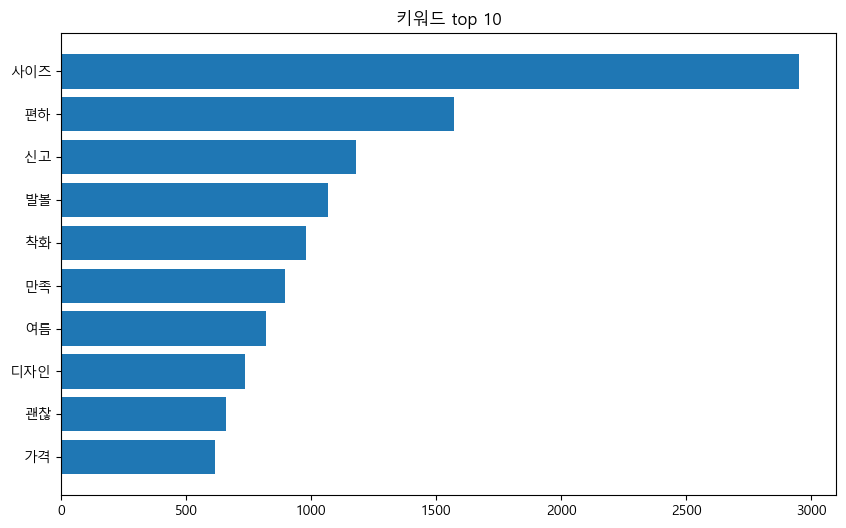

In [5]:
sort_token=token_df.sort_values(by='Frequency',ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(sort_token['Morpheme'],sort_token['Frequency'])
plt.title('키워드 top 10')
plt.gca().invert_yaxis() #y축 반전
plt.show()#

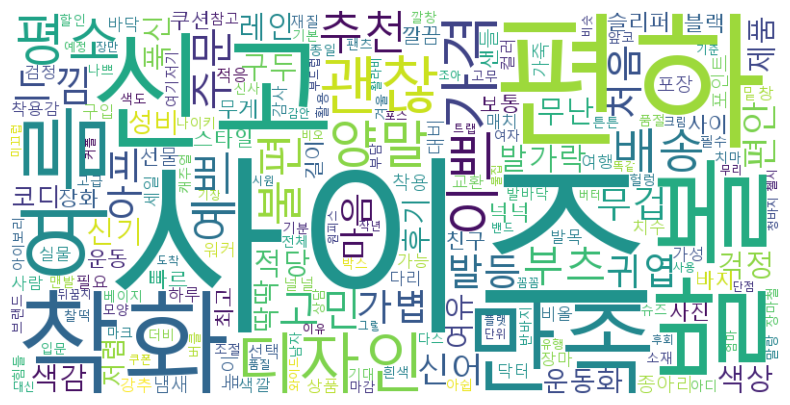

In [6]:
font_path='C:/Windows/Fonts/malgun.ttf'
# 워드클라우드 객체 생성
wordcloud = WordCloud(font_path=font_path, width = 800, height = 400, background_color ='white').generate_from_frequencies(token_counts)

# 워드클라우드 보여주기
plt.figure(figsize=(10, 5))  # 크기 조정
plt.imshow(wordcloud, interpolation="bilinear")  # 이미지 표시
plt.axis("off")  # 축 제거
plt.show()

In [7]:
id2word = corpora.Dictionary(tokenized_docs)
corpus = [id2word.doc2bow(doc) for doc in tokenized_docs]
columns_as_lists = tokenized_docs

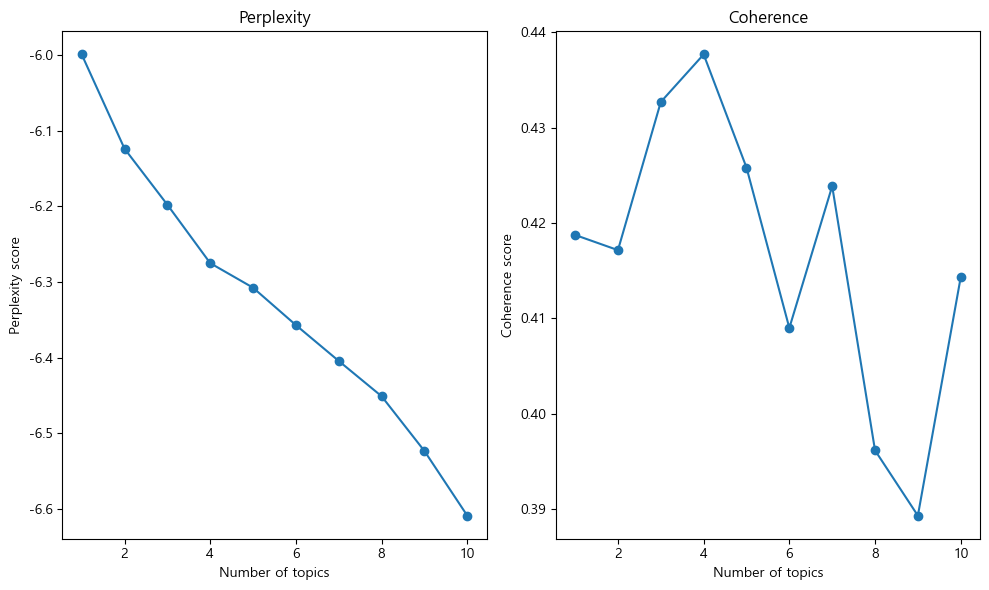

In [8]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt


start_topic = 1
end_topic = 10
step = 1
topic_range = range(start_topic, end_topic + 1, step)

# Perplexity 계산
perplexity_values = []
for i in topic_range:
    
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=id2word)
    perplexity_values.append(ldamodel.log_perplexity(corpus)) 

# Coherence 계산
coherence_scores = []
for i in topic_range:
    lda_model = LdaModel(corpus, num_topics=i, id2word=id2word, passes=15)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=columns_as_lists, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_score)


fig, axes = plt.subplots(1, 2, figsize=(10, 6))
x = topic_range
plt.rcParams['axes.unicode_minus'] = False

# Perplexity subplot
axes[0].plot(x, perplexity_values, marker='o')
axes[0].set_xlabel('Number of topics')
axes[0].set_ylabel('Perplexity score') 
axes[0].set_title('Perplexity') 


# Coherence subplot
axes[1].plot(topic_range, coherence_scores, marker='o')
axes[1].set_xlabel('Number of topics')
axes[1].set_ylabel('Coherence score')
axes[1].set_title('Coherence')


plt.tight_layout()
plt.show()

In [9]:
optimal_co = topic_range[coherence_scores.index(max(coherence_scores))]
print("최적토픽 수 : ", optimal_co)

최적토픽 수 :  4


In [10]:
lda_model = models.LdaModel(corpus, # 말뭉치
                            num_topics=optimal_co, # 최적의 주제수
                            id2word=id2word, # 단어사전
                            #chunksize=20, # 각 학습 단계에서 사용하는 문서의 수
                            #passes=15, # 말뭉치 반복 횟수
                            #iterations=100, # 각 문서에 대해 LDA 모델 반복 횟수
                            per_word_topics=True) # 각 단어에 대한 토픽 정보 저장

In [11]:
for topic_id, topic_words in lda_model.print_topics():
    print(f"Topic {topic_id}: {topic_words}") # 키워드 가중치, 키워드

Topic 0: 0.122*"사이즈" + 0.023*"발볼" + 0.023*"착화" + 0.022*"주문" + 0.021*"편하" + 0.020*"만족" + 0.020*"불편" + 0.017*"추천" + 0.017*"평소" + 0.015*"배송"
Topic 1: 0.041*"발볼" + 0.032*"아프" + 0.031*"신고" + 0.029*"발등" + 0.027*"사이즈" + 0.025*"평소" + 0.025*"마음" + 0.020*"편하" + 0.020*"구두" + 0.018*"운동화"
Topic 2: 0.060*"편하" + 0.045*"부츠" + 0.034*"사이즈" + 0.033*"레인" + 0.028*"여름" + 0.028*"신고" + 0.018*"처음" + 0.018*"귀엽" + 0.016*"가볍" + 0.016*"무겁"
Topic 3: 0.036*"디자인" + 0.033*"가격" + 0.031*"착화" + 0.030*"만족" + 0.024*"괜찮" + 0.024*"예쁘" + 0.018*"색감" + 0.015*"무난" + 0.014*"색상" + 0.014*"여름"


In [12]:
# dominant topic and its percentage contribution in each document

def topic_sentences(ldamodel=None, corpus=None, texts=None, df=None):
    topic_list = []

    # 문서별 토픽 할당
    for n in range(len(corpus)):
        doc_topic = ldamodel.get_document_topics(corpus[n], minimum_probability=0.0)
        doc_topic = sorted(doc_topic, key=lambda x: x[1], reverse=True)
        topic_most_pr = doc_topic[0][0]
        topic_pr = doc_topic[0][1]
        
        # 키워드 추출
        wp = ldamodel.show_topic(topic_most_pr)
        topic_keywords = ", ".join([word for word, prop in wp])
        
        topic_list.append([n, topic_most_pr, topic_pr, topic_keywords])
    
  
    topic_df = pd.DataFrame(topic_list, columns=['document_num', 'Dominant_Topic', 'Percentage', 'Keywords'])
    topic_df = topic_df.set_index('document_num')
    
    
    df = df.reset_index(drop=True)
    result_df = topic_df.join(df[['review']], how='inner')

    # 옵션 설정: 최대 컬럼 너비
    pd.set_option('display.max_colwidth', 1000)

    return result_df.reset_index(drop=True)


topic_df = topic_sentences(ldamodel=lda_model, corpus=corpus, texts=df['review'], df=df)

topic_df.head()

,Dominant_Topic,Percentage,Keywords,review
0,1,0.558205,"발볼, 아프, 신고, 발등, 사이즈, 평소, 마음, 편하, 구두, 운동화",푹신푹신해서 오래신어두 발 안아프고 좋으네용 코디에든 휘뚤마뚤 신을 수 있어서 좋아용
1,0,0.803418,"사이즈, 발볼, 착화, 주문, 편하, 만족, 불편, 추천, 평소, 배송",유니크하구 편안해보여서 구매했는데 좋습니다 오래 신을 거 같아요 정사이즈 입니당
2,3,0.865753,"디자인, 가격, 착화, 만족, 괜찮, 예쁘, 색감, 무난, 색상, 여름",생긴게 유니크하고 이뻐서 여름에 자주 신을 같습니다. 굽도 꽤 있어서 키높이 효과도 있은 같아요. 굽이 있는 무게도 꽤나 나간가는 점 무거운거 빼면 착화감은 좋습니다
3,0,0.486612,"사이즈, 발볼, 착화, 주문, 편하, 만족, 불편, 추천, 평소, 배송",까지긴 하는데 길들이는 시간이 필요한 같아요. 오래 신었더니 덜 까져요. 손이 어디에나 어울려서 여름에 잘 신었습니다
4,1,0.702111,"발볼, 아프, 신고, 발등, 사이즈, 평소, 마음, 편하, 구두, 운동화",신발 귀여워서 마음에 들어요 발볼 넓은 225인데 스트링 조이면 편하게 신고 다닐 수 있어요. 양말 신었다가 양쪽 발등에 상처가 심하게 났어요. 마감이 까끌하거나 그런건 아니고 발 사이즈에 비해 신발이 커서 스트링 조이는 부분이 걸을 때마다 쓸린 같아요 양말 신어도 이쁘긴해서 맨발에 신을 땐 밴드 붙이고 신어요 흔하지 않은 투박 귀여운 디자인에 밑창이 적당히 푹신해서 오래 걸어도 발이 아프지 않아요. 무엇보다 발볼이 꽤 넓어 225사이즈 운동화 신어도 새 끼 발가락이 항상 아픈데 발볼이 넉넉해서 발가락도 아프지 않습니다. 만족


In [13]:
# topic 별 가장 대표하는 review
representative_sen=topic_df.groupby('Dominant_Topic')['Percentage'].idxmax()

topic_df.loc[representative_sen]

,Dominant_Topic,Percentage,Keywords,review
5283,0,0.968655,"사이즈, 발볼, 착화, 주문, 편하, 만족, 불편, 추천, 평소, 배송",10만원대 저가의 더비슈즈와 비교하면 확실히 가죽의 퀄리티 디자인 착화감 사이즈 상담방식까지 차이가 납니다. 무신사 온라인 구매 이후 판매사에서 사이즈 상담 전화가 왔고 친절하게 사이즈 안내부터 추가 굽에 설명을 들을 수 있었고요 저는 운동화는 265사이즈를 신는데 맞게 신으려면 255사이즈 여유있게 신으려면 260사이즈인데 고민하다가 더비슈즈는 사이즈가 커보이는게 더 예쁠것 같아서 260을 선택했는데요. 생각한데로 편하게 신을 수 있을 같아요. 가죽 특성상 신다보면 볼이 늘어나는건 감안해야 할 같습니다. 주문제작 방식이라 배송 받기까지는 고지된 것과 약 2주 소요됐고요 앞에 약각 각지면서도 동글동글한게 디자인이 예뻐요. 무엇보다 가죽이 스크레치 좋고 마감도 깔끔해서 만족합니다. 앞으로 로스트가든을 자주 봐야겠어요
368,1,0.953146,"발볼, 아프, 신고, 발등, 사이즈, 평소, 마음, 편하, 구두, 운동화",편하게 신으려고 샀는데 옷 안가리고 다 잘어울려요 어그는38하니까 작아서 이번엔 250시켰는데 스포츠양말에도 넉넉하네요 평소 운동화240신고 구두같은건 250해야 잘맞아요 구겨 신어도 뒷축이 없어서 대충 구겨 발 넣어지니 신고벗고도 간편하네요 바닥은 얇아 오래신으면 아플듯해요 패딩류에도 맨투맨이나 후드에도 자켓 코트에도 다 잘어울릴거같아요
3611,2,0.963871,"편하, 부츠, 사이즈, 레인, 여름, 신고, 처음, 귀엽, 가볍, 무겁",원래는 톨을 사려고 했는데 플레이가 더 편하게 자주 신을 수 있을 같아서 플레이톨로 구매했어요 사이즈는 230 35신는데 230도 괜찮았어요. 양말 안 신으면 발등 쓸리는 느낌이라 양말은 꼭 신어줘야 해요. 종아리도 걸으면 쓸려서 빨개지긴 하는데 아파서 못 신겠다 아니에요 간지러운 긴바지보다는 반바지나 치마랑 입는 게 더 예쁜 같아요. 옆태 는 제가 생각했던 그대로인데 섰을 앞태가 다리 모양 때문인지 옆으로 퍼진 느낌이라 그건 아쉬웠어요. 무튼 저는 너무너무 만족합니다 여름 전에 사길 잘한 같아요. 요즘 레인부츠 신으려고 비오는 날 기다려요
522,3,0.959545,"디자인, 가격, 착화, 만족, 괜찮, 예쁘, 색감, 무난, 색상, 여름",츄바스코꺼 신어보고 싶었지만 여름 샌달은 비가 와도 신을 수 있는 걸 사야 의미가 있다고 생각해왔었는데 물에 들어갈 수 잇따고 해서 구매했어용 피쉬맨 디자인이 지나가고 있는 건 맞지만서도 신어보고 싶었는데 가격도 부담이 덜해서 구매해버렸슴다 착화감이 말랑한 게 좋았어요 저는 딱딱한 신발은 발바닥이 아파서 도저히 예뻐도 못신겠더라구요 착화감 말랑하고 조흥 데 단점이 발이 더워용 첨엔 양말신고 신어서 그렁가 했는데 맨발에 신어두 다 뚫려있지만 덥다능. 벗으면 천국이에요 착화감도 좋고 가격도 그렇구 물에도 들어갈 수 있는 거 생각하면은 괜찮다구 생각듭니닷


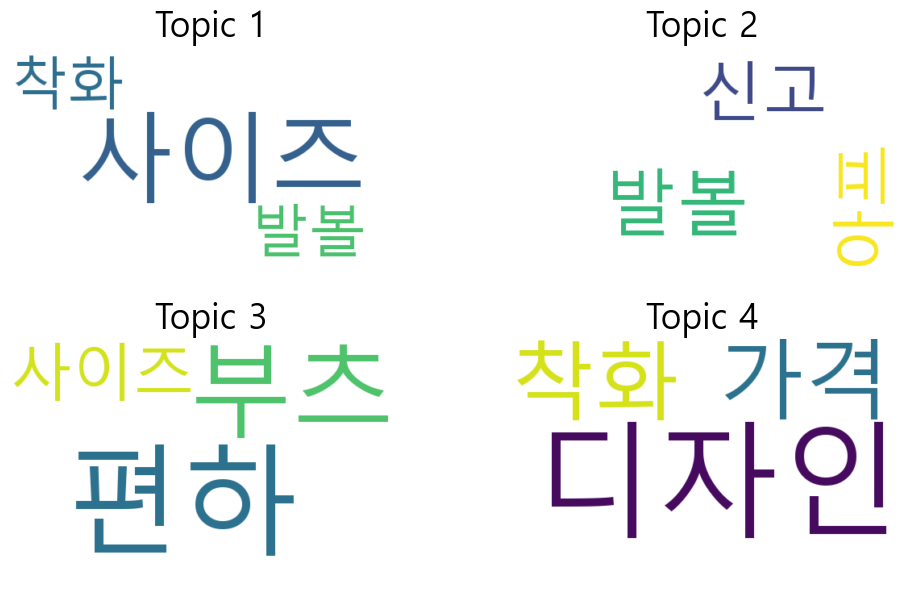

In [14]:
topic_df = topic_sentences(ldamodel=lda_model, corpus=corpus, texts=df['review'], df=df)

# 토픽별 워드 클라우드 생성( 가중치 시각화)
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
wordcloud = WordCloud(font_path=font_path,width=500, height=300, background_color='white')

for i, ax in enumerate(axes.flatten()):
    if i >= len(lda_model.get_topics()): 
        ax.axis('off')
        continue

    fig.add_subplot(ax)
    topic_words = dict(lda_model.show_topic(i, topn=3))  # 각 토픽의 상위 3개 키워드 사용
    wordcloud.generate_from_frequencies(topic_words)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('Topic ' + str(i+1), fontdict=dict(size=25))
    ax.axis('off')

plt.tight_layout()
plt.show()

C:\Users\jk032\AppData\Local\Temp\ipykernel_2420\3904257.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis', ax=ax)


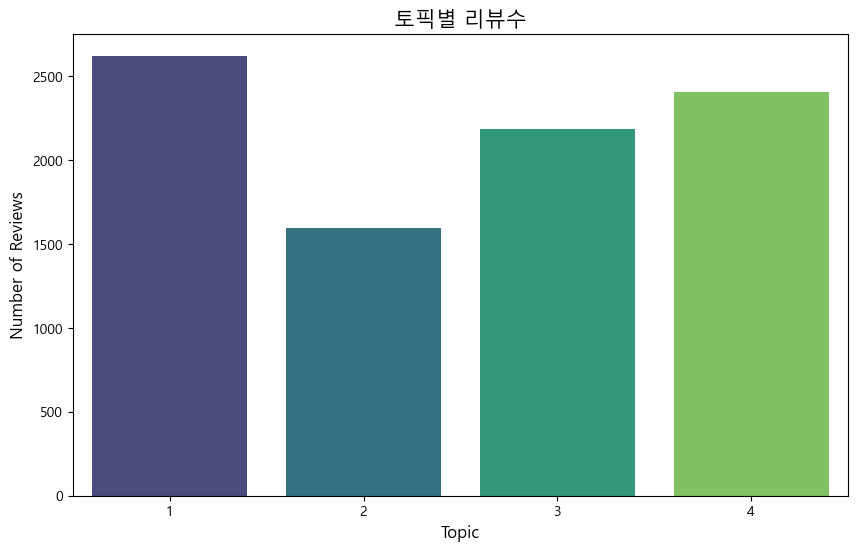

In [15]:
topic_df = topic_sentences(ldamodel=lda_model, corpus=corpus, texts=df['review'], df=df)

# 토픽별 리뷰 수
topic_counts = topic_df['Dominant_Topic'].value_counts().sort_index()

# 막대 차트 시각화
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis', ax=ax)
ax.set_title('토픽별 리뷰수', fontsize=15)
ax.set_xlabel('Topic', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)

ax.set_xticks(range(len(topic_counts)))
ax.set_xticklabels(range(1, len(topic_counts) + 1))

plt.xticks(rotation=0)
plt.show()

In [16]:
#pyLDA
vis = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis,local=False)

In [17]:
pyLDAvis.save_html(vis, 'lda_visualization_help1pos.html')
# file:///C:/Users/jk032/zerobase/mlproject/lda_visualization_help1pos.html
